<a href="https://colab.research.google.com/github/oaarnikoivu/dissertation/blob/master/Attention_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install transformers

     |████████████████████████████████| 645kB 3.4MB/s 
     |████████████████████████████████| 1.1MB 19.8MB/s 
     |████████████████████████████████| 890kB 21.9MB/s 
     |████████████████████████████████| 3.8MB 28.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=4d287db5f62d2b47ffa391f928bf21bf5fc03d3e9f81c6cd606b2f3fd6dac7aa
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Imports

In [0]:
import torch
import torchtext
import random
import re
import transformers
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from torchtext import data
from torchtext.vocab import GloVe
from transformers import BertTokenizer, BertModel, DistilBertTokenizer, DistilBertModel

In [0]:
print(torch.__version__)

1.5.0+cu101


# Arguments

In [0]:
args = {
    "bert_tokenizer": "bert-base-uncased",
    "bert_pretrained_model": "bert-base-uncased",
    "distilbert_tokenizer": "distilbert-base-uncased",
    "distilbert_pretrained_model": "distilbert-base-uncased",
    "seed": 1234,
    "bert_embedding_dim": 768,
    "use_glove": False,
    "glove_embedding_dim": 300,
    "max_vocab_size": 20000,
    "batch_size": 10,
    "output_dim": 11,
    "hidden_size": 256,
    "num_layers": 2,
    "dropout": 0.3,
    "fc_dropout": 0.5,
    "embed_dropout": 0.3,
    "weight_decay": 1e-5,
    "lr": 0.001,
    "epochs": 10
}

# Text pre-processor

In [0]:
def preprocessor(text):
  text = re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  text = (re.sub('[\W]+', ' ', text.lower()) +
          ' '.join(emoticons).replace('-', '')) 
  return text.split()

In [0]:
og_text = '#Good music I love that #shit.'
processed = preprocessor(og_text)
processed

['good', 'music', 'i', 'love', 'that', 'shit']

# Setup Bert Tokenizer

In [0]:
tokenizer = BertTokenizer.from_pretrained(args['bert_tokenizer'])
# tokenizer = DistilBertTokenizer.from_pretrained(args['distilbert_tokenizer'])

In [0]:
max_input_length = tokenizer.max_model_input_sizes[args['bert_tokenizer']]
# max_input_length = tokenizer.max_model_input_sizes[args['distilbert_tokenizer']]

print(max_input_length)

512


In [0]:
def tokenize(tweet):
  tokens = tokenizer.tokenize(tweet)
  tokens = tokens[:max_input_length-2]
  return tokens

# Load and Generate Data

In [0]:
file_path = '/content/drive/My Drive'

DATA_PATH = Path(file_path + '/datasets/SemEval')

random.seed(args['seed'])
np.random.seed(args['seed'])
torch.manual_seed(args['seed'])
torch.backends.cudnn.deterministic = True

if args['use_glove']:
  TEXT = data.Field(batch_first=True,
                    tokenize=preprocessor,
                    use_vocab=True,
                    sequential=True)
else:
  TEXT = data.Field(batch_first = True,
                use_vocab = False,
                tokenize = tokenize,
                preprocessing = tokenizer.convert_tokens_to_ids,
                init_token = tokenizer.cls_token_id,
                eos_token = tokenizer.sep_token_id,
                pad_token = tokenizer.pad_token_id,
                unk_token = tokenizer.unk_token_id)
  
LABEL = data.LabelField(sequential = False,
                        use_vocab = False,
                        pad_token= None,
                        unk_token = None, 
                        dtype = torch.float)

dataFields = {"Tweet": ("Tweet", TEXT),
              'anger': ("anger", LABEL),
              'anticipation': ("anticipation", LABEL),
              'disgust': ("disgust", LABEL),
              'fear': ("fear", LABEL),
              'joy': ("joy", LABEL),
              'love': ("love", LABEL),
              'optimism': ("optimism", LABEL),
              'pessimism': ("pessimism", LABEL),
              'sadness': ("sadness", LABEL),
              'surprise': ("surprise", LABEL),
              'trust': ("trust", LABEL)}

train_data, valid_data, test_data = data.TabularDataset.splits(
    path = DATA_PATH,
    train = 'train.csv',
    validation = 'val.csv',
    test = 'test.csv',
    format = 'csv',
    fields = dataFields
)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: len(x.Tweet),
    sort_within_batch = True,
    batch_size = args['batch_size'],
    device = device
)

In [0]:
if args['use_glove']:
  TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300), 
                   max_size=args['max_vocab_size'])
  print(f"\nUnique tokens in TEXT vocabulary: {len(TEXT.vocab)}")

# Batch Wrapper

In [0]:
LABEL_COLS = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
              'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

iaux = 0

for batch in valid_iterator:
  iaux += 1
  aux = batch
  aux2 = torch.stack([getattr(batch, label) for label in LABEL_COLS])
  if aux == 20: break;

# Build the Model

Load the pretrained bert model from the HuggingFace transformers library.

https://github.com/huggingface/transformers

In [0]:
bert = BertModel.from_pretrained(args['bert_pretrained_model'])
# bert = DistilBertModel.from_pretrained(args['distilbert_pretrained_model'])

Use model architecture proposed at: https://www.aclweb.org/anthology/P16-2034/

In [0]:
class Attention(nn.Module):
  def __init__(self, hidden_size):
    super(Attention, self).__init__()

    self.attention = nn.Linear(hidden_size, 1)

  def forward(self, H):
    M = torch.tanh(H)
    M = self.attention(M).squeeze(2)
    alpha = F.softmax(M, dim=1).unsqueeze(1)
    return alpha

class AttentionBiLSTM(nn.Module):
  def __init__(self, hidden_size, num_layers, dropout, fc_dropout, 
               emb_layer_dropout, num_classes):
    super(AttentionBiLSTM, self).__init__()

    self.hidden_size = hidden_size
    
    if args['use_glove']:
      embedding_dim = args['glove_embedding_dim']
      self.embedding = nn.Embedding(len(TEXT.vocab), embedding_dim)
    else:
      self.bert = bert
      embedding_dim = args['bert_embedding_dim']
    
    # embedding layer dropout
    self.emb_layer_dropout = nn.Dropout(emb_layer_dropout)

    # lstm layer
    self.lstm = nn.LSTM(embedding_dim, 
                        hidden_size, 
                        num_layers, 
                        dropout=(0 if num_layers==1 else dropout),
                        bidirectional=True,
                        batch_first=True)
    
    # penultimate layer
    self.fc = nn.Linear(hidden_size, num_classes)
    self.fc_dropout = nn.Dropout(fc_dropout)
    
    self.attention = Attention(hidden_size)
  
  def forward(self, text):
    if args['use_glove']:
      embedded = self.embedding(text)
    else:
      with torch.no_grad():
        embedded = self.bert(text)[0]

    embedded = self.emb_layer_dropout(embedded)
    y, _ = self.lstm(embedded)
    y = y[:,:,:self.hidden_size] + y[:,:,self.hidden_size:]
    alpha = self.attention(y)
    r = alpha.bmm(y).squeeze(1)
    h = torch.tanh(r)
    logits = self.fc(h)
    logits = self.fc_dropout(logits)
    return logits, alpha 

In [0]:
model = AttentionBiLSTM(
    hidden_size=args['hidden_size'],
    num_layers=args['num_layers'],
    dropout=args['dropout'],
    fc_dropout=args['fc_dropout'],
    emb_layer_dropout=args['embed_dropout'],
    num_classes=args['output_dim'],
)


model

AttentionBiLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

Freeze the parameters which are a part of the Bert Transformers model. 

In [0]:
if args['use_glove'] is False:
  for name, param in model.named_parameters():                
      if name.startswith('bert'):
          param.requires_grad = False

Show the trainable parameters.

In [0]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
lstm.weight_ih_l0_reverse
lstm.weight_hh_l0_reverse
lstm.bias_ih_l0_reverse
lstm.bias_hh_l0_reverse
lstm.weight_ih_l1
lstm.weight_hh_l1
lstm.bias_ih_l1
lstm.bias_hh_l1
lstm.weight_ih_l1_reverse
lstm.weight_hh_l1_reverse
lstm.bias_ih_l1_reverse
lstm.bias_hh_l1_reverse
fc.weight
fc.bias
attention.attention.weight
attention.attention.bias


# Train the Model

In [0]:
import torch.optim as optim 

In [0]:
optimizer = optim.Adam(model.parameters(), weight_decay=args['weight_decay'])
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We evaluate using the Jaccard index and the macro and micro F1's as there are more suitable for multi-label text classification problems.

In [0]:
from sklearn.metrics import roc_auc_score, f1_score, jaccard_score

In [0]:
def metricize(preds, y):
  f1_macro = f1_score(y, preds.round(), average='macro')
  f1_micro = f1_score(y, preds.round(), average='micro')
  #acc = roc_auc_score(y, preds)
  jaccard = jaccard_score(y, preds.round(), average='samples')

  return {
      'f1_macro': f1_macro,
      'f1_micro': f1_micro,
      'jaccard': jaccard,
  }

In [0]:
def train(model, iterator, optimizer, criterion):

  epoch_loss = 0

  model.train()

  preds_list = []
  labels_list = []

  for i, batch in enumerate(iterator):
    
    optimizer.zero_grad()

    predictions, _ = model(batch.Tweet)

    batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
    batch_labels = torch.transpose(batch_labels, 0, 1)

    loss = criterion(predictions, batch_labels)

    loss.backward()

    optimizer.step()

    preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
    labels_list += [batch_labels.cpu().numpy()]

    epoch_loss += loss.item()
  
  return epoch_loss / len(iterator), metricize(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
def evaluate(model, iterator, criterion):

  epoch_loss = 0

  model.eval()

  preds_list = []
  labels_list = []

  with torch.no_grad():
    
    for batch in iterator:

      predictions, _ = model(batch.Tweet)
     
      batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
      batch_labels = torch.transpose(batch_labels, 0, 1)

      loss = criterion(predictions, batch_labels)

      epoch_loss += loss.item()

      preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
      labels_list += [batch_labels.cpu().numpy()]

  return epoch_loss / len(iterator), metricize(np.vstack(preds_list),
                                             np.vstack(labels_list)), preds_list, labels_list

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We train the model for 10 epochs and record the training and validation loss. 

In [0]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

train_acc = []
valid_acc = []

for epoch in range(args['epochs']):

    start_time = time.time()
    
    train_loss, train_metrics = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_metrics, _, _, = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        if args['use_glove']:
          torch.save(model.state_dict(), 'glove-lstm-model.pt')
        else:
          torch.save(model.state_dict(), 'bert-lstm-model.pt')
        
    train_jaccard = train_metrics['jaccard']
    train_micro = train_metrics['f1_micro']
    train_macro = train_metrics['f1_macro']

    valid_jaccard = valid_metrics['jaccard']
    valid_micro = valid_metrics['f1_micro']
    valid_macro = valid_metrics['f1_macro']

    train_acc.append(train_jaccard)
    valid_acc.append(valid_jaccard)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Jaccard: {train_jaccard*100:.2f}% | Train F1 Micro: {train_micro*100:.2f}% | Train F1 Macro: {train_macro*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} | Val. Jaccard: {valid_jaccard*100:.2f}%  | Val. F1 Micro: {valid_micro*100:.2f}%  | Val. F1 Macro: {valid_macro*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01 | Epoch Time: 0m 29s
	Train Loss: 0.559 | Train Jaccard: 14.02% | Train F1 Micro: 23.92% | Train F1 Macro: 14.01%
	 Val. Loss: 0.464 | Val. Jaccard: 36.10%  | Val. F1 Micro: 50.12%  | Val. F1 Macro: 31.18%
Epoch: 02 | Epoch Time: 0m 29s
	Train Loss: 0.533 | Train Jaccard: 21.41% | Train F1 Micro: 33.92% | Train F1 Macro: 22.13%
	 Val. Loss: 0.417 | Val. Jaccard: 44.88%  | Val. F1 Micro: 57.24%  | Val. F1 Macro: 37.92%
Epoch: 03 | Epoch Time: 0m 29s
	Train Loss: 0.517 | Train Jaccard: 23.79% | Train F1 Micro: 36.87% | Train F1 Macro: 24.82%
	 Val. Loss: 0.390 | Val. Jaccard: 47.94%  | Val. F1 Micro: 60.60%  | Val. F1 Macro: 41.16%
Epoch: 04 | Epoch Time: 0m 29s
	Train Loss: 0.507 | Train Jaccard: 25.55% | Train F1 Micro: 39.11% | Train F1 Macro: 27.98%
	 Val. Loss: 0.384 | Val. Jaccard: 50.83%  | Val. F1 Micro: 64.21%  | Val. F1 Macro: 46.21%
Epoch: 05 | Epoch Time: 0m 29s
	Train Loss: 0.505 | Train Jaccard: 26.52% | Train F1 Micro: 40.46% | Train F1 Macro: 29.39%
	 Val. Loss:

# Visualize the training and validation loss 

In [0]:
import matplotlib.pyplot as plt

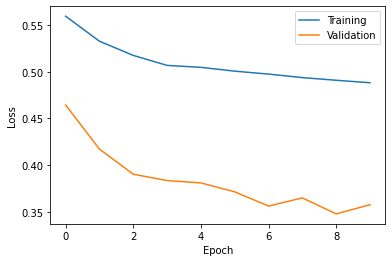

In [0]:
plt.plot(train_losses)
plt.plot(valid_losses)
# plt.title('Attention LSTM (GloVe) Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])

# plt.savefig('attn-lstm-glove', dpi=300)

# Visualize the training and validation jaccard accuracy

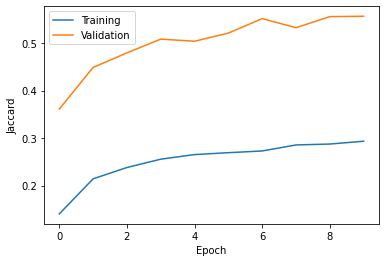

In [0]:
plt.plot(train_acc)
plt.plot(valid_acc)
# plt.title('Attention LSTM (GloVe) Training & Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Jaccard')
plt.legend(['Training', 'Validation'])
# plt.savefig('attn-lstm-acc-glove', dpi=300)

# Assess model performance on testing data

In [0]:
if (args['use_glove']):
  model.load_state_dict(torch.load('glove-lstm-model.pt'))
else:
  model.load_state_dict(torch.load('bert-lstm-model.pt'))


test_loss, test_metrics, preds_list, labels_list = evaluate(model, test_iterator, criterion)

test_jaccard = test_metrics['jaccard']
test_micro = test_metrics['f1_micro']
test_macro = test_metrics['f1_macro']

print(f'Test Loss: {test_loss:.3f} | Test Jaccard: {test_jaccard*100:.2f}% | Test F1 Micro: {test_micro*100:.2f}% | Test F1 Macro: {test_macro*100:.2f}%')

Test Loss: 0.347 | Test Jaccard: 55.74% | Test F1 Micro: 67.50% | Test F1 Macro: 50.20%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Confusion matrix & Classification report

In [0]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report

conf_matrix = multilabel_confusion_matrix(np.vstack(labels_list), np.vstack(preds_list).round())
print(conf_matrix)

cm = classification_report(np.vstack(labels_list), np.vstack(preds_list).round())
print(cm)

[[[1961  197]
  [ 327  774]]

 [[2797   37]
  [ 385   40]]

 [[1903  257]
  [ 323  776]]

 [[2710   64]
  [ 219  266]]

 [[1585  232]
  [ 252 1190]]

 [[2576  167]
  [ 239  277]]

 [[1748  368]
  [ 306  837]]

 [[2809   75]
  [ 318   57]]

 [[2069  230]
  [ 347  613]]

 [[3081    8]
  [ 162    8]]

 [[3091   15]
  [ 142   11]]]
              precision    recall  f1-score   support

           0       0.80      0.70      0.75      1101
           1       0.52      0.09      0.16       425
           2       0.75      0.71      0.73      1099
           3       0.81      0.55      0.65       485
           4       0.84      0.83      0.83      1442
           5       0.62      0.54      0.58       516
           6       0.69      0.73      0.71      1143
           7       0.43      0.15      0.22       375
           8       0.73      0.64      0.68       960
           9       0.50      0.05      0.09       170
          10       0.42      0.07      0.12       153

   micro avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Inference

In [0]:
def predict_emotion(model, tokenizer, tweet):
  preds = []
  model.eval()

  if args['use_glove']:
    tokenized = preprocessor(tweet)
    indexed = [TEXT.vocab.stoi[token] for token in tokenized]
  else:
    tokens = tokenizer.tokenize(tweet)
    tokens = tokens[:max_input_length-2]
    indexed = [tokenizer.cls_token_id] + tokenizer.convert_tokens_to_ids(tokens) + [tokenizer.sep_token_id]

  tensor = torch.LongTensor(indexed).to(device)
  tensor = tensor.unsqueeze(0)
  predictions, attn_weights = model(tensor)
  preds.append(torch.sigmoid(predictions).detach().cpu().numpy())

  if args['use_glove']:
    return preds, attn_weights, tokenized
  else:
    return preds, attn_weights, tokens

Lets test the model on our own input and save the attention weights and tokens for visualization. 

In [0]:
text = "Good music I love that shit"

preds, attn_weights, tokens = predict_emotion(model, tokenizer, text)

pred_values = []
for p in preds[0]:
  for val in p:
    pred_values.append(val)

for i, label in enumerate(LABEL_COLS):
  print(f"{label.upper()}: {pred_values[i]}")

ANGER: 0.16969524323940277
ANTICIPATION: 0.3801114857196808
DISGUST: 0.231175497174263
FEAR: 0.45125430822372437
JOY: 0.37219494581222534
LOVE: 0.11220299452543259
OPTIMISM: 0.526516854763031
PESSIMISM: 0.38130509853363037
SADNESS: 0.4075164198875427
SURPRISE: 0.19744563102722168
TRUST: 0.2266409695148468


Here we format the attention weights and store the results in a dictionary

In [0]:
attention_weights = []
for aw in attn_weights[0]:
  for v in aw:
    attention_weights.append(v.detach().cpu().numpy())

if args['use_glove']:
  attention_weights = np.array(attention_weights)
else:
  attention_weights = attention_weights[1:-1]
  attention_weights = np.array(attention_weights)

attention_weights

array([0.00254789, 0.01076373, 0.01684024, 0.07311631, 0.03186547,
       0.00803466, 0.00655064, 0.00805102, 0.006072  , 0.00671965,
       0.00279574, 0.00230082, 0.00309695, 0.00623091, 0.01081251,
       0.00539237, 0.00246369, 0.00121749, 0.00773399, 0.01135166,
       0.02006537, 0.00754995, 0.00213846, 0.0062455 , 0.00142177,
       0.00407601, 0.02648655, 0.01255506, 0.00345027, 0.00315737,
       0.00614974, 0.00364961, 0.00330923, 0.00152066, 0.00148461,
       0.00315663, 0.00177615, 0.00131094, 0.00086917, 0.00151383,
       0.00099399, 0.00142413, 0.00168227, 0.0029159 , 0.00265497,
       0.00214023, 0.00235863, 0.00307832, 0.00656858, 0.0074112 ,
       0.00699761, 0.00281964, 0.00213332, 0.00229799, 0.00137846,
       0.00245026, 0.00362945, 0.00184601, 0.00223766, 0.0024562 ,
       0.00296904, 0.00319508, 0.0019913 , 0.0028417 , 0.00260649,
       0.00242163, 0.0027601 , 0.00238864, 0.00289053, 0.00456507,
       0.00244693, 0.00219304, 0.00211479, 0.00142508, 0.00162

In [0]:
attn_dict = {}
for i in range(len(attention_weights)):
  attn_dict[tokens[i]] = attention_weights[i]

print(attn_dict)

{'i': 0.005714731, "'": 0.0009789616, 'm': 0.01120737, 'only': 0.07311631, '24': 0.03186547, ',': 0.004024698, 'and': 0.005153555, 'have': 0.011505663, 'worked': 0.0060719987, 'part': 0.0020768465, 'time': 0.0013986574, 'jobs': 0.0013109408, 'since': 0.0030969537, 'graduated': 0.010812506, 'from': 0.0036496134, 'college': 0.0024636856, '.': 0.0019596778, 'with': 0.007733991, 'everything': 0.018388906, 'going': 0.020065365, 'on': 0.007549953, 've': 0.0040760064, 'been': 0.026486548, 'fur': 0.012555063, '##lou': 0.0034502705, '##gh': 0.0031573689, '##ed': 0.0061497386, 'both': 0.0033092287, 'of': 0.0015206585, 'my': 0.0010810941, 'well': 0.03816426, 'one': 0.0009939926, 'offered': 0.0014241328, 'me': 0.0016822703, 'full': 0.0036294525, 'was': 0.006568577, 'able': 0.0074112, 'to': 0.00065362296, 'negotiate': 0.0028196427, 'the': 0.00424025, 'salary': 0.0022979937, 'up': 0.001378462, 'a': 0.0016248557, 'dollar': 0.0018460079, 'per': 0.0022376643, 'hour': 0.0024562003, '!': 0.0029355057, 'i

Lets return the top 3 words that the model focused on. 

In [0]:
from collections import Counter

In [0]:
weight_counter = Counter(attn_dict)
print(weight_counter)

Counter({'excited': 0.10658169, 'hoping': 0.091825165, 'only': 0.07311631, 'well': 0.03816426, '24': 0.03186547, 'been': 0.026486548, 'so': 0.020243872, 'going': 0.020065365, 'money': 0.019635389, 'just': 0.019175567, 'everything': 0.018388906, 'out': 0.014234467, 'for': 0.013029293, 'can': 0.012844201, 'fur': 0.012555063, 'works': 0.011590307, 'have': 0.011505663, 'm': 0.01120737, 'graduated': 0.010812506, 'as': 0.008603161, 'with': 0.007733991, 'gr': 0.007715879, 'on': 0.007549953, 'able': 0.0074112, 'was': 0.006568577, 'that': 0.0064747864, 'especially': 0.006318355, '##ed': 0.0061497386, 'worked': 0.0060719987, 'i': 0.005714731, 'and': 0.005153555, 'fall': 0.005041964, 'know': 0.0045650653, 'the': 0.00424025, '##ad': 0.0041371533, 've': 0.0040760064, ',': 0.004024698, 'in': 0.003876382, 'from': 0.0036496134, 'full': 0.0036294525, '##lou': 0.0034502705, 'both': 0.0033092287, 'yet': 0.003262018, '##gh': 0.0031573689, 'school': 0.003127283, 'since': 0.0030969537, '!': 0.0029355057, 'h

# Model performance on longer text

In [0]:
import os

In [0]:
text_1 = (
    "I'm only 24, and have worked part time jobs since I graduated from college." 
    " With everything going on, I've been furloughed from both of my part time jobs."
    " Well one offered me full time, and I was able to negotiate the salary up a full dollar per hour! And it has benefits and everything!" 
    " I know it's not a big deal but I'm just so excited and can't really tell anyone"
    " especially as I haven't spoken to my other part time job yet. Just hoping everything works out well, and that I have money for grad school in the fall!"
)

text_2 = (
    "I worked my ass off to graduate with my Bachelor's in 3 years."
    "My family hasn't said a word to me about it. No 'Congrats'! or 'I'm proud of you!'."
    "And it's not like they don't know. I live with them. I got my cap & gown in the mail last week and one my"
    " professors snet me a graduation card. They were there for all of it. Still, not a single word about it."
    " I know this is a weird time, but I don't think that's an excuse to ignore your daughter's life achievements."
    " I feel so under-appreciated. I just want them to tell me they're proud. What kind of parent doesn't do that?"
    " I'm 20 years old with a Bachelor of Science in Information Technology. I deserve a pat on the back."
    " This really sucks."
)

preds, attn_weights, tokens = predict_emotion(model, tokenizer, text_2)

pred_values = []
for p in preds[0]:
  for val in p:
    pred_values.append(val)

# print(os.linesep.join(["I'm only 24, and have worked part time jobs since I graduated from college.", 
#                        "With everything going on, I've been furloughed from both of my part time jobs.",
#                        "Well one offered me full time, and I was able to negotiate the salary up a full dollar per hour!", 
#                        "And it has benefits and everything! I know it's not a big deal but I'm just so excited and", 
#                        "can't really tell anyone, especially as I haven't spoken to my other part time job yet.", 
#                        "Just hoping everything works out well, and that I have money for grad school in the fall!"]))

print(os.linesep.join(["I worked my ass off to graduate with my Bachelor's in 3 years.", 
                      "My family hasn't said a word to me about it. No 'Congrats'! or 'I'm proud of you!'.",
                      "And it's not like they don't know. I live with them. I got my cap & gown in the mail last week and one my",
                      "professors snet me a graduation card. They were there for all of it. Still, not a single word about it.",
                      "I know this is a weird time, but I don't think that's an excuse to ignore your daughter's life achievements.",
                      "I feel so under-appreciated. I just want them to tell me they're proud. What kind of parent doesn't do that?",
                      "I'm 20 years old with a Bachelor of Science in Information Technology. I deserve a pat on the back.",
                      "This really sucks."]))

print()

print("Text length: 138 words")

print()
for i, label in enumerate(LABEL_COLS):
  print(f"{label.upper()}: {pred_values[i]:.2f}")

I worked my ass off to graduate with my Bachelor's in 3 years.
My family hasn't said a word to me about it. No 'Congrats'! or 'I'm proud of you!'.
And it's not like they don't know. I live with them. I got my cap & gown in the mail last week and one my
professors snet me a graduation card. They were there for all of it. Still, not a single word about it.
I know this is a weird time, but I don't think that's an excuse to ignore your daughter's life achievements.
I feel so under-appreciated. I just want them to tell me they're proud. What kind of parent doesn't do that?
I'm 20 years old with a Bachelor of Science in Information Technology. I deserve a pat on the back.
This really sucks.

Text length: 138 words

ANGER: 0.28
ANTICIPATION: 0.14
DISGUST: 0.39
FEAR: 0.22
JOY: 0.33
LOVE: 0.12
OPTIMISM: 0.37
PESSIMISM: 0.35
SADNESS: 0.58
SURPRISE: 0.13
TRUST: 0.14
